# Modelling and scientific computing - SABS 2019 demonstration
## Iterative method for solving linear systems

I found this tutorial quite useful to explain some math logic behind the methods: https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
def get_lower_triangle(A):
    n = len(A)
    L = np.zeros((n,n),dtype=float)
    for i in range(0,n):
        L[i][:i] = A[i][:i]
    return L

Using Richardson iteration to implement Jacobi, Gauss_Seicdel and SOR altogether:

**Richardson iteration**:

For solving the linear system **x**: $$A \mathbf{x} = \mathbf{b}$$ , where $A$ is a square matrix

We iteratively solve:
$$ M\mathbf{x}^{k+1} = N\mathbf{x}^{k}+\mathbf{b} $$
until convergence, where $A=M-N$ is a **splitting** of the matrix $A$.
For the method to be useful we have to require:
1. Solving the linear system $M\mathbf{y} = \mathbf{f}$ is easy.
2. The iteration converges to $\mathbf{x} = A^{-1}\mathbf{b}$.
3. The speed of convergence is fast.


$D =$ dianogal matrix of $A$; $L =$ strictly lower trianglular matrix of $A$; $R =$ strictly upper trianglular matrix of $A$
* Jacobi: $M = D$, $N = -(L+U)$
* Gauss_Seicdel: $M = (L+D)$, $N = -U$
* SOR: $M = \omega^{-1}D + L$, $N = \omega^{-1}[(1-\omega)D -\omega U]$

if the spectral radius of $\rho (M^{-1}U)$ is close to unity then convergence can be very slow.
For SOR,We would like to choose the relaxation parameter $\omega$ to minimise the spectral radius $\rho((D + \omega L)^{-1}[(1-\omega)D-\omega U])$:
For certain matrices, with a specific structure, such a choice is known. In general finding a suitable $\omega$ is not straightforward.

Explanation of why $\rho(M^{-1}N)$ is relevant to the convergence of Jacobi and Gauss-Seicdel iteration: Section 5.2 of https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

In [81]:
def Richardson_iteration(A,b,method,omega, k): #,error): Successive over relaxation
    A = np.array(A)
    b = np.array(b)
    n = len(b)
    L = get_lower_triangle(A)
    D = np.diag(A)*np.eye((n))
    U = A-L-D
    
    if method == 'Jacobi':
        M = D
        N = -(L+U)
    elif method == 'Gauss_Seicdel':
        M = L+D
        N = -U
    elif method == 'SOR':
        M = (1.0/omega)*D+L
        N = (1.0/omega)*((1.0-omega)*D-omega*U)
    else:
        return("Please indicate one ieteration method from ['Jacobi', 'Gauss_Seicdel', 'SOR']")
    eigvals = np.linalg.eig(np.linalg.inv(M)@N)[0] # spectral radius of M^(-1)N
    
    x_each_ite = []
    x = np.zeros((n),dtype=float)
    x_each_ite.append(x)
    
    error_ite = []
    error_ite.append(np.linalg.norm(A@x - b,2))
    ite = 0
    
    #while sum((A@x-b)**2) > error:
    # Only do 4 iterations
    while ite < k:
        x = np.linalg.inv(M)@(b+N@x)
        error_ite.append(np.linalg.norm(A@x - b,2))
        ite += 1
        x_each_ite.append(x)
        #if k<=4:
         #   x_first_four_ite.append(x)
    #num_ite = len(error_ite)-1
    if method == 'SOR':
        label = method + ', omega='+str(omega) + ', error=%s'%error
    else:
        label = method + ', error=%s'%error
    #plt.semilogy(np.linspace(0,num_ite,num_ite+1),error_ite,'o-',label = label )
    return x, x_each_ite,method,eigvals, error_ite   

In [82]:
# calculate 2-norm error for each iteration:
def two_norm_error(x_result, x_exact):
    num_ite = len(x_result)
    error = [np.linalg.norm(x_result[i] - x_exact,2) for i in range(num_ite)]
    return error

In [116]:
#) 5b,c,d,e

def compare_result_exact(A,b,x0, x_exact, methods):
    print ('Exact result:', x_exact,'\n')

    plt.figure()
    for method in methods:
        if method != 'SOR':
            result = Richardson_iteration(A,b,method=method,omega = 0,k=4)
            print (result[2], '\nresults for each iteration:', result[1]) # print results of first k iterations, method
            error_ite = two_norm_error(result[1], x_exact)
            print ('2-norm error for each iteration: ',result[-1],'\n','eigenvalues of M^(-1)N: ', result[-2],'\n')
            plt.semilogy(error_ite,label = method,alpha=0.5)
        else:
            for omega in ([1.01, 1.03, 1.05]):
                result = Richardson_iteration(A,b,omega=omega,method=method,k=4)
                print (result[2], 'omega =', omega, '\n, results for each iteration:', result[1]) # print results of first k iterations, method
                error_ite = two_norm_error(result[1], x_exact)
                print ('2-norm error for each iteration: ', result[-1],'\n')
                plt.semilogy(error_ite,label = method+', omega=%s'%omega,alpha=0.5)
    plt.legend()


Exact result: [0.10344828 0.37931034 0.37931034 0.10344828] 

Jacobi 
results for each iteration: [array([0., 0., 0., 0.]), array([0.2, 0.4, 0.4, 0.2]), array([0.08, 0.36, 0.36, 0.08]), array([0.112, 0.384, 0.384, 0.112]), array([0.1008, 0.3776, 0.3776, 0.1008])]
2-norm error for each iteration:  [3.1622776601683795, 0.8944271909999161, 0.2828427124746188, 0.09121403400793111, 0.029502542263337386] 
 eigenvalues of M^(-1)N:  [-0.3236068  0.3236068 -0.1236068  0.1236068] 

Gauss_Seicdel 
results for each iteration: [array([0., 0., 0., 0.]), array([0.2 , 0.4 , 0.36, 0.08]), array([0.112 , 0.384 , 0.3776, 0.1008]), array([0.10432 , 0.37984 , 0.379136, 0.103168]), array([0.1035392 , 0.3793664 , 0.37929216, 0.10341888])]
2-norm error for each iteration:  [3.1622776601683795, 0.4472135954999579, 0.04367150100465973, 0.004566031099324661, 0.0004781446810330156] 
 eigenvalues of M^(-1)N:  [0.         0.         0.01527864 0.10472136] 

SOR omega = 1.01 
, results for each iteration: [array([0.

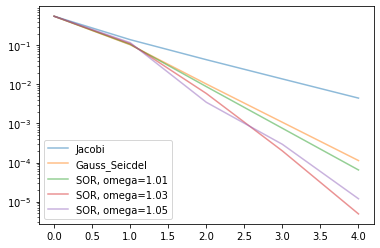

In [117]:
#) 5b,c,d,e
A =  [[5, 0, 1, 1,],
      [0, 5, 0, 1,],
      [1, 0, 5, 0],
      [1, 1, 0, 5,]]
b = [1,2,2,1]
x0 = [0,0,0,0]

x_exact = np.linalg.inv(A)@b

methods = ['Jacobi', 'Gauss_Seicdel', 'SOR']

compare_result_exact(A,b,x0,x_exact, methods)

$\uparrow$  Comment: $\rho(M^{-1}N) = 0.3 $ for Jacobi, which is larger than $0.1$ for Gauss_Seicdel, so the convergence rate of Gauss_Seicdel is higher than Jacobi.

Exact result: [0. 1. 1. 0.] 

Jacobi 
results for each iteration: [array([0., 0., 0., 0.]), array([0.5, 1. , 1. , 0.5]), array([-0.25,  0.75,  0.75, -0.25]), array([0.25 , 1.125, 1.125, 0.25 ]), array([-0.1875,  0.875 ,  0.875 , -0.1875])]
2-norm error for each iteration:  [3.1622776601683795, 2.23606797749979, 1.7677669529663689, 1.4252192813739224, 1.1524430571616109] 
 eigenvalues of M^(-1)N:  [ 0.80901699 -0.80901699  0.30901699 -0.30901699] 

Gauss_Seicdel 
results for each iteration: [array([0., 0., 0., 0.]), array([ 0.5 ,  1.  ,  0.75, -0.25]), array([ 0.25  ,  1.125 ,  0.875 , -0.1875]), array([ 0.15625 ,  1.09375 ,  0.921875, -0.125   ]), array([ 0.1015625 ,  1.0625    ,  0.94921875, -0.08203125])]
2-norm error for each iteration:  [3.1622776601683795, 0.5590169943749475, 0.19764235376052372, 0.12597277731716483, 0.08240243402237886] 
 eigenvalues of M^(-1)N:  [0.        0.        0.0954915 0.6545085] 



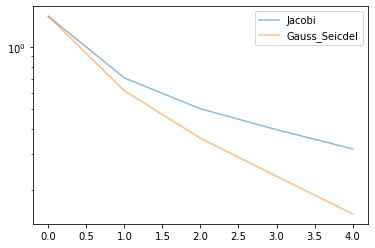

In [118]:
# 5f. repeat for different A
A =  [[2, 0, 1, 1,],
      [0, 2, 0, 1,],
      [1, 0, 2, 0],
      [1, 1, 0, 2,]]
b = [1,2,2,1]
x0 = [0,0,0,0]
x_exact = np.linalg.inv(A)@b
methods = ['Jacobi', 'Gauss_Seicdel']

compare_result_exact(A,b,x0,x_exact,methods)

$\uparrow$  $\rho(M^{-1}N) = 0.81 $ for Jacobi, which is larger than $0.65$ for Gauss_Seicdel, so the convergence rate of Gauss_Seicdel is higher than Jacobi.

In [ ]:
A =  [[1, 0, 1, 1,],
      [0, 1, 0, 1,],
      [1, 0, 1, 0],
      [1, 1, 0, 1,]]
b = [1,2,2,1]
x0 = [0,0,0,0]
x_exact = np.linalg.inv(A)@b
methods = ['Jacobi', 'Gauss_Seicdel']

compare_result_exact(A,b,x0,x_exact,methods)

$\uparrow$ Did not converge because $\rho(M^{-1}N) > 1! $ (1.6 in Jacobi, 2.6 in Gauss_Seicdel) 

### Steepest descent
A matrix $A$ is positive defnite if $\mathbf{x}^TA\mathbf{x} > 0$ for all $\mathbf{x} \neq 0$.
$A$ is positive semidefnite if $\mathbf{x}^TA\mathbf{x} \geq 0$ for all $x \neq 0$.

can be quite slow if $\lambda_1/\lambda_n$ of $A$ is very large. In this case, the gradient directions that arise at
each iteration are very similar so progress towards the minimum cannot be improved significantly at each step

### Conjugate gradient descent
$\mathbf{p}_k$ is $A$-conjugate to {$\mathbf{p}_1$, $\mathbf{p}_2$,...,$\mathbf{p}_{k-1}$}, and $\mathbf{x}_{k-1}$ $\in$ {$\mathbf{p}_1$, $\mathbf{p}_2$,...,$\mathbf{p}_{k-1}$}, so $\mathbf{p}_k^TA\mathbf{x}_{k-1}=0$ 

We are now left with the problem of finding $\mathbf{p}k$ such that $\mathbf{p}_{k-1}^TA\mathbf{p}^k = 0$ and $\mathbf{p}_k^Tr_{k-1} \neq 0$

Explanation of why $\lambda_1/\lambda_n$ of $A$ affects the convergence rate: Section 6.1 of https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf

In [129]:
def gd_initialization(A,b,x0):
    A = np.array(A)
    b = np.array(b)
    x = x0
    r = b - A@x # r: residual (r0: initual residual)
    
    error = np.linalg.norm(r)
    error_ite = []
    error_ite.append(error)
    return A, b, x, r, error, error_ite  # initialization of x, r, error error_ite (the record of error) 

def steepest_descent(A,b,x0,termination): #termination: criteria to terminate(number of iterations, error with a certain tolerance)
    A, b, x, r, error, error_ite = gd_initialization(A,b,x0)
    k = 0 #keep the record of the number of iterations
    
    while k < termination[1]: #termination[1]: maximun number of iteration set manually
        if error>termination[0]: #termination[0]: error tolerance
            k += 1
            alpha = (r.T@r)/(r.T@A@r)
            x = x + alpha*r
            r = b - A@x
            error = np.linalg.norm(r)
            error_ite.append(error)
            # callback: When the system runs more than 10 iterations, 
            # if the error successively increases for 5 iterations, break
            if k>10: 
                if error_ite[k] > error_ite[k-1] and error_ite[k-1] > error_ite[k-2] and error_ite[k-3] > error_ite[k-4] and error_ite[k-4] > error_ite[k-5]:
                    break
        else:
            break
    return x, error_ite


def conjugate_gradient_descent(A,b,x0,termination): #termination: criteria to terminate(number of iterations, error with a certain tolerance)
    A, b, x, r, error, error_ite = gd_initialization(A,b,x0)
    k = 0
    p = r #initial value of p equals r
    
    while k < termination[1]:
        if error>termination[0]:
            k += 1
            alpha = (p.T@r)/(p.T@A@p) #step length == (r.T@r)/(p.T@A@p)
            x = x + alpha*p    # approximate solution

            r_new = r - alpha*A@p   # residual, == b - A@x
            #r_new = b - A@x
            beta = (r_new.T@r_new)/(r.T@r)  # improvement for p_(k+1)
            p = r_new + beta*p  # new search direction
            r = r_new
            error = np.linalg.norm(r,2)
            error_ite.append(error)
            #print(error,k)
            if k>10:
                if error_ite[k] > error_ite[k-1] and error_ite[k-1] > error_ite[k-2] and error_ite[k-3] > error_ite[k-4] and error_ite[k-4] > error_ite[k-5]:
                    break
        else:
            break
    return x, error_ite
    

In [130]:
# 6a) solve the system in question 5 using steepest descent and conjugated gradient descent
A =  [[5, 0, 1, 1,],
      [0, 5, 0, 1,],
      [1, 0, 5, 0],
      [1, 1, 0, 5,]]
b = [1,2,2,1]
x0 = [0,0,0,0]

conditional number:  1.9568599940788902


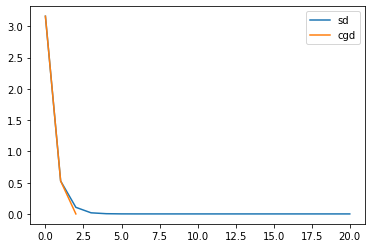

In [131]:
print ('conditional number: ', max(np.linalg.eig(A)[0])/min(np.linalg.eig(A)[0]))
plt.figure()
x_result,error_result = steepest_descent(A,b,x0,[1e-14,100])
plt.plot(error_result,label='sd')

x_result,error_result = conjugate_gradient_descent(A,b,x0,[1e-14,100])
plt.plot(error_result,label = 'cgd')
plt.legend()

A200: 
ratio of the largest and the smallest eigenvalue of A200 is 800.7222407590754
min error of steepest descent is: 4.937637638284638
min error of conjugate gradient descent is: 0.01012393409259745
A400: 
ratio of the largest and the smallest eigenvalue of A400 is 1558.7719009339596
min error of steepest descent is: 4.7368651227003
min error of conjugate gradient descent is: 0.12285040127558937
A800: 
ratio of the largest and the smallest eigenvalue of A800 is 3152.4872383370976
min error of steepest descent is: 7.575965977691756
min error of conjugate gradient descent is: 1.1631508207372259


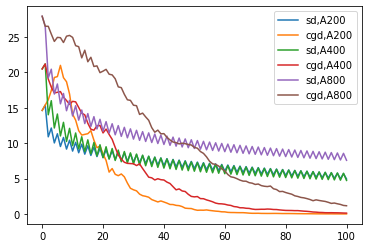

In [133]:
# 6b,c,d

# Construct a n by n random matrix, Bn and a column vector bn of length n. An = I + BTn@Bn:
def large_random_system(n): # A is an n*n matrix
    B_n = np.reshape(np.random.randn(n*n),(n,n))
    b_n = np.random.randn(n)
    A_n = np.eye(n)+B_n.T@B_n
    return A_n, b_n

plt.figure()
for n in [200,400,800]:
    print('A%s: '%n)
    A,b=large_random_system(n)
    print('ratio of the largest and the smallest eigenvalue of A%s is '%n + str(max(np.linalg.eig(A)[0])/min(np.linalg.eig(A)[0])))
    
    x0=np.zeros(n)
    
    tol = 1e-5; max_ite = 100  # set the tolerance of error and max number of iteration
    
    x_sd,error_sd = steepest_descent(A,b,x0,[tol,max_ite])
    plt.plot(np.linspace(0,len(error_sd)-1,len(error_sd)),error_sd,label = 'sd,A%s'%n)
    
    print('min error of steepest descent is: '+ str(min(error_sd)))
    
    x_cgd,error_cgd = conjugate_gradient_descent(A,b,x0,[tol,max_ite])
    plt.plot(np.linspace(0,len(error_cgd)-1,len(error_cgd)),error_cgd,label = 'cgd,A%s'%n)
    print('min error of conjugate gradient descent is: '+ str(min(error_cgd)))
    
plt.legend()

$\lambda_1/\lambda_2$ increases from $A_{200}$ to $A_{400}$ and to $A_{800}$, so the convergence rate is decreasing as the size of $A$ increases (in this case) in both steepest descent and conjugate gradient descent, respectively.